<img src="./sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate">

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3<br>
<font color=696880 size=4>
    Ashkan Majidi - Shayan Salehi - Amirhossein Alamdar

____

# Personal Data

In [1]:
student_number = '400104867'
first_name = 'Payam'
last_name = 'Taebi'

# Introduction

In this assignment, you will implement SVM (Support Vector Machines) for classification.


# Data Prepfocessing

Import your needed libraries in following cell.

In [2]:
!pip install cvxopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 65.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from cvxopt import matrix, solvers
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Load data from ```satimage``` dataset and split data to features and labels. The ```label``` column is our target variable.

In [4]:
try:
    data = pd.read_csv('/kaggle/input/satimage/satimage.csv')
    #data = data[(data['label'] == 4) | (data['label'] == 6)]
    #data.reset_index(drop=True, inplace=True)
    #data['label'] = data['label'].apply(lambda x: 1 if x == 6 else -1)

    print(data.info())
except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print("An error occurred:", e)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6435 non-null   float64
 1   1       6435 non-null   float64
 2   2       6435 non-null   float64
 3   3       6435 non-null   float64
 4   4       6435 non-null   float64
 5   5       6435 non-null   float64
 6   6       6435 non-null   float64
 7   7       6435 non-null   float64
 8   8       6435 non-null   float64
 9   9       6435 non-null   float64
 10  10      6435 non-null   float64
 11  11      6435 non-null   float64
 12  12      6435 non-null   float64
 13  13      6435 non-null   float64
 14  14      6435 non-null   float64
 15  15      6435 non-null   float64
 16  16      6435 non-null   float64
 17  17      6435 non-null   float64
 18  18      6435 non-null   float64
 19  19      6435 non-null   float64
 20  20      6435 non-null   float64
 21  21      6435 non-null   float64
 22  

In [5]:
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Labels

print("Number of samples labeled as 1:", (y == 1).sum())
print("Number of samples labeled as -1:", (y == -1).sum())


print("Shape of features (X):", X.shape)
print("Shape of labels (y):", y.shape)

Number of samples labeled as 1: 1533
Number of samples labeled as -1: 0
Shape of features (X): (6435, 36)
Shape of labels (y): (6435,)


Now split data to train, validation and test parts. 60% of data should be used for train, 15% for validation and 25% for test. After that scale the data to Standard Normal Distribution using ```StandardScaler``` class from ```scikit-learn``` library.

In [6]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Filter out specific labels
mask_train = (y_train == 4) | (y_train == 6)
mask_test = (y_test == 4) | (y_test == 6)
mask_val = (y_val == 4) | (y_val == 6)

X_train = X_train[mask_train]
X_test = X_test[mask_test]
X_val = X_val[mask_val]

y_train = y_train[mask_train]
y_test = y_test[mask_test]
y_val = y_val[mask_val]

# Convert labels to binary
y_train.replace({4: -1, 6: 1}, inplace=True)
y_test.replace({4: -1, 6: 1}, inplace=True)
y_val.replace({4: -1, 6: 1}, inplace=True)

# Print shapes of datasets
datasets = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}
for name, data in datasets.items():
    print(f"Shape of {name}: {data.shape}")

Shape of X_train: (1266, 36)
Shape of y_train: (1266,)
Shape of X_val: (330, 36)
Shape of y_val: (330,)
Shape of X_test: (538, 36)
Shape of y_test: (538,)


We want to train Binary SVM model for classification between labels 4 and 6. Choose corresponding datas and convert their lables to 1 and -1 respectively for 4 and 6.

# Model (50 points)

Here is soft margin svm convex optimization formulation.
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
\text { Subject to } & y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right) \geq 1-\xi_i, \quad i=1,2, \ldots, N \\
& \xi_i \geq 0, \quad i=1,2, \ldots, N
\end{aligned}
$$
write dual of the soft margin svm optimization problem below:

\begin{align*}
\text{Maximize} & \quad \sum_{i=1}^{N} \alpha_i - \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j \mathbf{x}_i^T \mathbf{x}_j \\
\text{Subject to} & \quad 0 \leq \alpha_i \leq C \quad \text{for } i=1,2,\ldots,N \\
& \quad \sum_{i=1}^{N} \alpha_i y_i = 0
\end{align*}


Now you should write this optimization problem in standard Quadratic Program (QP) form and use a QP solver to find optimal answer. Here is General form of a QP:
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2} x^TPx + q^Tx + r \\
\text { Subject to } & Gx \leq h \\
& Ax = b
\end{aligned}
$$

Complete functions below and use ```cvxopt``` library which is a common library for solving QPs. Note that you can't use ```scikit-learn``` library.


For the soft margin SVM problem, the standard QP formulation can be obtained as follows:

\begin{align*}
\text{Minimize} & \quad \frac{1}{2} \mathbf{\alpha}^T \mathbf{Q} \mathbf{\alpha} - \mathbf{e}^T \mathbf{\alpha} \\
\text{Subject to} & \quad -\mathbf{\alpha} \leq \mathbf{0} \\
& \quad \mathbf{\alpha} \leq C \\
& \quad \mathbf{y}^T \mathbf{\alpha} = 0 \\
\end{align*}

Where:

\begin{align*}
\mathbf{\alpha} & \text{ is the vector of Lagrange multipliers.} \\
\mathbf{Q} & \text{ is a positive definite matrix defined as } \mathbf{Q}_{ij} = y_i y_j \mathbf{x}_i^T \mathbf{x}_j. \\
\mathbf{e} & \text{ is a vector of ones.} \\
\mathbf{y} & \text{ is the vector of labels.} \\
C & \text{ is the regularization parameter.}
\end{align*}


In [7]:
def soft_margin_svm(X, y, C):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
    output:
        support_vectors: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    """
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)

    n_samples = X.shape[0]
    K = np.dot(X, X.T)
    P = matrix((np.outer(y, y) * K).astype(float))
    q = matrix((-np.ones((n_samples, 1))).astype(float))
    G = matrix((np.vstack((np.eye(n_samples) * (-1), np.eye(n_samples)))).astype(float))
    h = matrix((np.hstack((np.zeros(n_samples), np.ones(n_samples) * C))).astype(float))
    A = matrix((y.reshape(1, -1)).astype(float))
    b = matrix(np.array([0.0]).astype(float))

    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x'])
    sv = (alphas > 1e-5).flatten()

    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    return support_vectors, support_vector_labels, support_vector_alphas

In [8]:
C = 1.0
support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C)

     pcost       dcost       gap    pres   dres
 0: -6.1265e+02 -3.3971e+03  2e+04  3e+00  2e-13
 1: -4.1824e+02 -2.2816e+03  3e+03  3e-01  1e-13
 2: -3.9732e+02 -7.6474e+02  4e+02  3e-02  1e-13
 3: -4.4111e+02 -5.8227e+02  2e+02  9e-03  1e-13
 4: -4.6125e+02 -5.3708e+02  8e+01  4e-03  1e-13
 5: -4.7293e+02 -5.1305e+02  4e+01  2e-03  1e-13
 6: -4.7763e+02 -5.0407e+02  3e+01  1e-03  1e-13
 7: -4.8272e+02 -4.9477e+02  1e+01  4e-04  1e-13
 8: -4.8534e+02 -4.9054e+02  5e+00  2e-04  1e-13
 9: -4.8671e+02 -4.8840e+02  2e+00  4e-05  1e-13
10: -4.8718e+02 -4.8773e+02  6e-01  7e-06  1e-13
11: -4.8738e+02 -4.8747e+02  9e-02  4e-07  1e-13
12: -4.8742e+02 -4.8743e+02  7e-03  3e-08  1e-13
13: -4.8742e+02 -4.8742e+02  2e-04  6e-10  1e-13
Optimal solution found.


In [9]:
def predict_labels(x_test, support_vectors, support_vector_labels, support_vector_alphas):
    """
    input:
        x_test: test data
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    output:
        y_pred: predictoin labels
    """

    y_pred = np.zeros(len(x_test))
    for i, x in enumerate(x_test):
        prediction = 0
        for alpha, sv_label, sv in zip(support_vector_alphas, support_vector_labels, support_vectors):
            prediction += alpha * sv_label * np.dot(sv, x)
        y_pred[i] = np.sign(prediction.item())
    return y_pred.astype(int)

In [10]:
y_pred = predict_labels(np.array(X_test), support_vectors, support_vector_labels, support_vector_alphas)

# Evaluation (20 points)

Compute accuracy, balanced accuracy and plot confusion matrix of your trained model using ```Seaborn.heatmap()``` function. Use case of balanced accuracy is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other and it is defined by average of recall of classes. Confusion matrix is a $k\times k$ (k is number of classes) matrix which cell ij is showing that number of data points labeld i which predicted j. For more detail of evaluation metrics you can see [here](https://neptune.ai/blog/balanced-accuracy).

You may use ```scikit-learn``` library to compute these metrics.

In [11]:
def evaluate(y_test, y_pred):
    """
    input:
        y_test: true labels
        y_pred: predicted labels
    output:
        accuracy: accuracy of the model
        balanced_accuracy: balanced accuracy of the model
        confusion_matrix: confusion matrix of the model
    """
    # TODO: Write your code here

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    return accuracy, balanced_accuracy, confusion_mat


_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.8252788104089219
Balanced Accuracy:  0.7639855133496167
Confusion Matrix:
 [[ 96  59]
 [ 35 348]]


<Axes: >

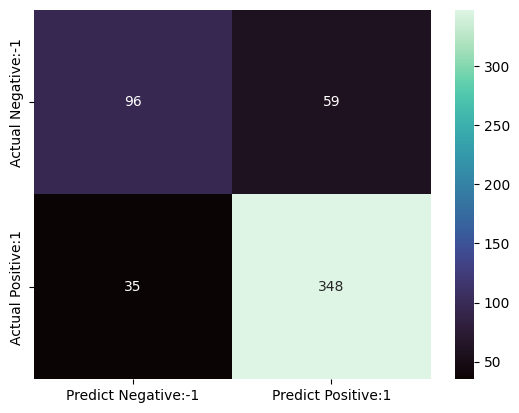

In [12]:
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predict Negative:-1', 'Predict Positive:1'],
                                 index=['Actual Negative:-1', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Fine-tunning (40 points)

like what you did before, implement Soft Margin SVM but now use rbf kernel. To determine rbf $\gamma$ parameter use validation datas and find best(best by balanced accuracy) $\gamma$ between 0.001 , 0.01, 1, 10, 100. Not that you can't use ```scikit-learn``` library here.

In [13]:
def rbf(x1, x2, gamma=1):
    """
    input:
        x1: first vector
        x2: second vector
        gamma: rbf kernel parameter with defalt value 1.
    output:
        ouput: computed rbf of two input vectors
    """
    # TODO: Write your code here
    distance = np.linalg.norm(x1 - x2) ** 2
    output = np.exp(-gamma * distance)
    return output

def soft_margin_svm(X, y, C, gamma=1):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
        gamma: rbf kernel parameter with defalt value 1.
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    """

    n_samples, n_features = X.shape

    # Compute the Gram matrix using the RBF kernel
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = rbf(X[i], X[j], gamma)

    # Construct matrices for QP solver
    P = matrix((np.outer(y, y) * K).astype(float))
    q = matrix(-np.ones((n_samples, 1)).astype(float))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))).astype(float))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)).astype(float))
    A = matrix(y.reshape(1, -1).astype(float))
    b = matrix(np.array([0.0]).astype(float))

    # Solve QP problem
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x']).flatten()

    # Extract support vectors
    sv_indices = alphas > 1e-5
    support_vectors = X[sv_indices]
    support_vector_labels = y[sv_indices]
    support_vector_alphas = alphas[sv_indices]

    return support_vectors, support_vector_labels, support_vector_alphas

In [14]:
from sklearn.metrics import balanced_accuracy_score

gammas = [0.01, 0.1, 1, 10, 100]
best_accuracy = 0
best_gamma = None
best_support_vectors = None
best_support_vector_labels = None
best_support_vector_alphas = None

for gamma in gammas:
    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train.values, C, gamma)
    y_pred = predict_labels(X_val, support_vectors, support_vector_labels, support_vector_alphas)
    accuracy = balanced_accuracy_score(y_val, y_pred)
    print("Gamma:", gamma, "Accuracy:", accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_gamma = gamma
        best_support_vectors = support_vectors
        best_support_vector_labels = support_vector_labels
        best_support_vector_alphas = support_vector_alphas

print("Best gamma:", best_gamma)


     pcost       dcost       gap    pres   dres
 0: -5.7870e+02 -3.1897e+03  2e+04  3e+00  2e-14
 1: -4.0863e+02 -2.0634e+03  2e+03  2e-01  1e-14
 2: -4.2109e+02 -6.8997e+02  3e+02  2e-02  1e-14
 3: -4.6476e+02 -5.9584e+02  1e+02  8e-03  1e-14
 4: -4.8769e+02 -5.5091e+02  7e+01  3e-03  1e-14
 5: -4.9596e+02 -5.3660e+02  4e+01  2e-03  1e-14
 6: -5.0371e+02 -5.2370e+02  2e+01  8e-04  1e-14
 7: -5.0860e+02 -5.1604e+02  8e+00  2e-04  1e-14
 8: -5.1083e+02 -5.1270e+02  2e+00  4e-05  2e-14
 9: -5.1160e+02 -5.1168e+02  8e-02  4e-07  2e-14
10: -5.1164e+02 -5.1164e+02  6e-03  1e-08  2e-14
11: -5.1164e+02 -5.1164e+02  3e-04  6e-10  2e-14
Optimal solution found.
Gamma: 0.01 Accuracy: 0.620575221238938
     pcost       dcost       gap    pres   dres
 0: -3.5478e+02 -2.9645e+03  1e+04  3e+00  5e-15
 1: -2.5774e+02 -1.8143e+03  2e+03  1e-01  4e-15
 2: -2.7515e+02 -5.5668e+02  3e+02  2e-02  4e-15
 3: -3.1035e+02 -4.0746e+02  1e+02  5e-03  4e-15
 4: -3.2161e+02 -3.7676e+02  6e+01  2e-03  4e-15
 5: -3.

In [15]:
y_pred = predict_labels(np.array(X_test), best_support_vectors, best_support_vector_labels, best_support_vector_alphas)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.8085501858736059
Balanced Accuracy:  0.7426345489766697
Confusion Matrix:
 [[ 91  64]
 [ 39 344]]


# Multiclass SVM (30 points + 50 points optional)

Now we want implement Multiclass SVM. Use ```SVC``` function with rbf kernel from ```scikit-learn``` package on all train datas (all six classes) and choose best hyperparameters for $C$ and $\gamma$ between 0.01, 0.1, 1, 10, 100. After that evaluate it with your function.

Note that in this example we had enough data to split them in train and validation but in case that we don't have enough data, ```scikit-learn``` has a built-in fast library named ```GridSearchCV()``` which can help us in hyperparameter tunning with cross validation.

Accuracy: 0.9028749028749029


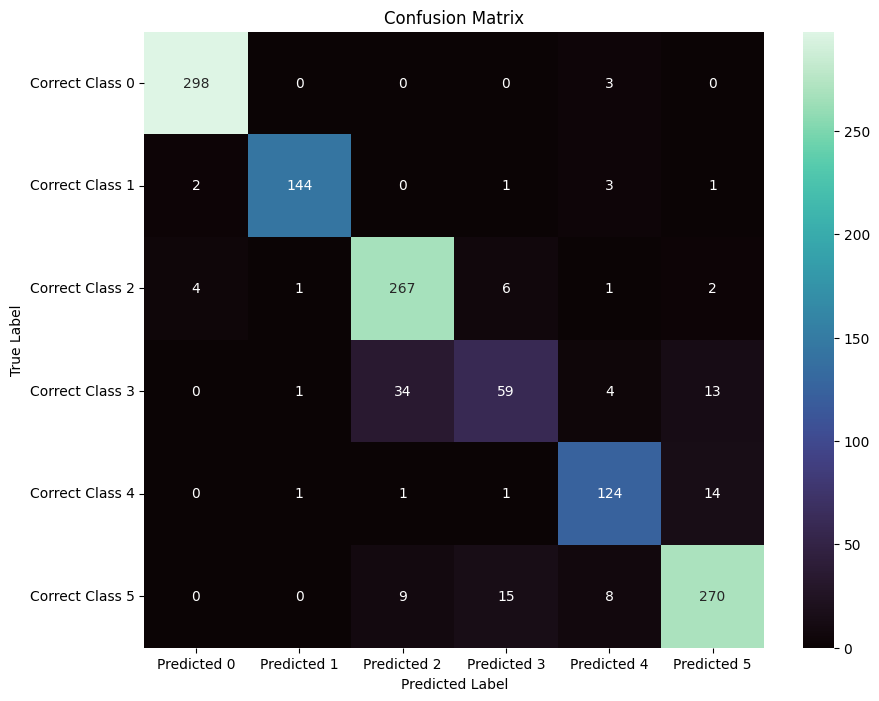

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/kaggle/input/satimage/satimage.csv')

X = data.drop(columns=['label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]}

svc = SVC(kernel='rbf')

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

best_svc = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
best_svc.fit(X_train, y_train)

y_pred = best_svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

confusion_mat = confusion_matrix(y_test, y_pred)

num_classes = 6
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predicted ' + str(i) for i in range(num_classes)],
                         index=['Correct Class ' + str(i) for i in range(num_classes)])
plt.figure(figsize=(10, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Implement Multiclass SVM from scratch without using ready functions (optional).

     pcost       dcost       gap    pres   dres
 0: -6.2955e-13 -5.1480e+03  2e+04  1e+00  1e-15
 1:  2.4718e-13 -1.3356e+03  1e+03  1e-02  6e-16
 2:  1.5526e-15 -1.3486e+01  1e+01  1e-04  4e-16
 3:  1.5352e-17 -1.3486e-01  1e-01  1e-06  5e-16
 4:  1.5352e-19 -1.3486e-03  1e-03  1e-08  4e-16
 5:  1.5352e-21 -1.3486e-05  1e-05  1e-10  4e-16
 6:  1.5352e-23 -1.3486e-07  1e-07  1e-12  3e-16
 7:  1.5352e-25 -1.3486e-09  1e-09  1e-14  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6004e+03 -8.4882e+03  2e+04  1e+00  1e-15
 1: -1.5188e+03 -4.5114e+03  3e+03  8e-14  4e-16
 2: -1.5711e+03 -1.7070e+03  1e+02  3e-13  6e-16
 3: -1.6036e+03 -1.6080e+03  4e+00  3e-14  2e-16
 4: -1.6048e+03 -1.6051e+03  2e-01  6e-15  2e-16
 5: -1.6049e+03 -1.6049e+03  1e-02  4e-14  2e-16
 6: -1.6049e+03 -1.6049e+03  3e-04  6e-14  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.5291e+02 -7.8521e+03  3e+04  2e+00  1e-15
 1: -7.7748e+02 -3.7033e

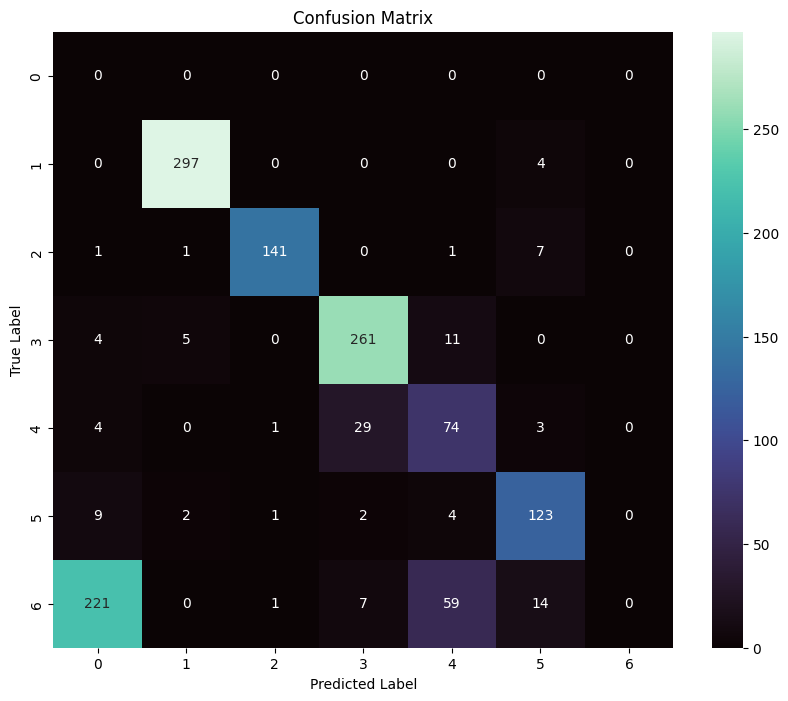

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix


def rbf(x1, x2, gamma=1):
    """
    input:
        x1: first vector
        x2: second vector
        gamma: rbf kernel parameter with defalt value 1.
    output:
        ouput: computed rbf of two input vectors
    """
    # TODO: Write your code here
    distance = np.linalg.norm(x1 - x2) ** 2
    output = np.exp(-gamma * distance)
    return output

def soft_margin_svm(X, y, C, gamma=1):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
        gamma: rbf kernel parameter with defalt value 1.
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    """

    n_samples, n_features = X.shape

    # Compute the Gram matrix using the RBF kernel
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = rbf(X[i], X[j], gamma)

    # Construct matrices for QP solver
    P = matrix((np.outer(y, y) * K).astype(float))
    q = matrix(-np.ones((n_samples, 1)).astype(float))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))).astype(float))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)).astype(float))
    A = matrix(y.reshape(1, -1).astype(float))
    b = matrix(np.array([0.0]).astype(float))

    # Solve QP problem
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x']).flatten()

    # Extract support vectors
    sv_indices = alphas > 1e-5
    support_vectors = X[sv_indices]
    support_vector_labels = y[sv_indices]
    support_vector_alphas = alphas[sv_indices]

    return support_vectors, support_vector_labels, support_vector_alphas



def predict_multi_class(x_test, classifiers, best_gamma):
    num_classes = len(classifiers)
    num_samples = len(x_test)
    predictions = np.zeros((num_samples, num_classes))

    for i, (support_vectors, support_vector_labels, support_vector_alphas) in enumerate(classifiers):
        for j in range(num_samples):
            prediction = 0
            for alpha, labell, sv in zip(support_vector_alphas, support_vector_labels, support_vectors):
                prediction += alpha * labell * rbf(x_test[j], sv, best_gamma)
            predictions[j, i] = prediction

    y_pred = np.argmax(predictions, axis=1)
    return y_pred

def evaluate(y_true, y_pred):
    confusion_mat = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy, confusion_mat

best_C = 1.0
best_gamma = 1.0
num_classes = 6

classifiers = []
for class_label in range(num_classes):
    binary_labels = np.where(y_train == class_label, 1, -1)
    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, binary_labels, best_C, best_gamma)
    classifiers.append((support_vectors, support_vector_labels, support_vector_alphas))

y_pred = predict_multi_class(X_test, classifiers, best_gamma)

accuracy, confusion_mat = evaluate(y_test, y_pred)
print("Accuracy:", accuracy)

cm_matrix = pd.DataFrame(data=confusion_mat)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Different SVM Kernels (40 points)

A kernel in SVM is like a tool that helps solve tricky problems. It lets us work in a space with many dimensions, making complex calculations easier. With kernels, we can deal with lots of dimensions, even an endless amount. Kernels are crucial for sorting data into groups and help spot patterns in the data we're looking at. They're especially good at tackling twisty problems with a straightforward approach.

Sometimes, finding a straight line or flat surface to divide data isn't possible, especially as we explore more dimensions. That's where different types of SVM kernels come in handy. They transform twisty, complicated data into a simpler form that's easier to separate. In this explanation, we talk about 4 popular types of these kernels. Also in following cells you can use any package.

<img src="./kernel.jpg" alt="Types of Kernel Functions"  align=center class="saturate">

### Linear Kernel

This is the simplest kind of kernel, typically working in one dimension. It works best when dealing with a lot of features. Linear kernels are quicker than other types.

**Formula:**

$$F(x, x_j) = sum(x, x_j)$$

Now Implement svc classifier using a linear kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix by `Seaborn`.

Accuracy: 0.8764568764568764


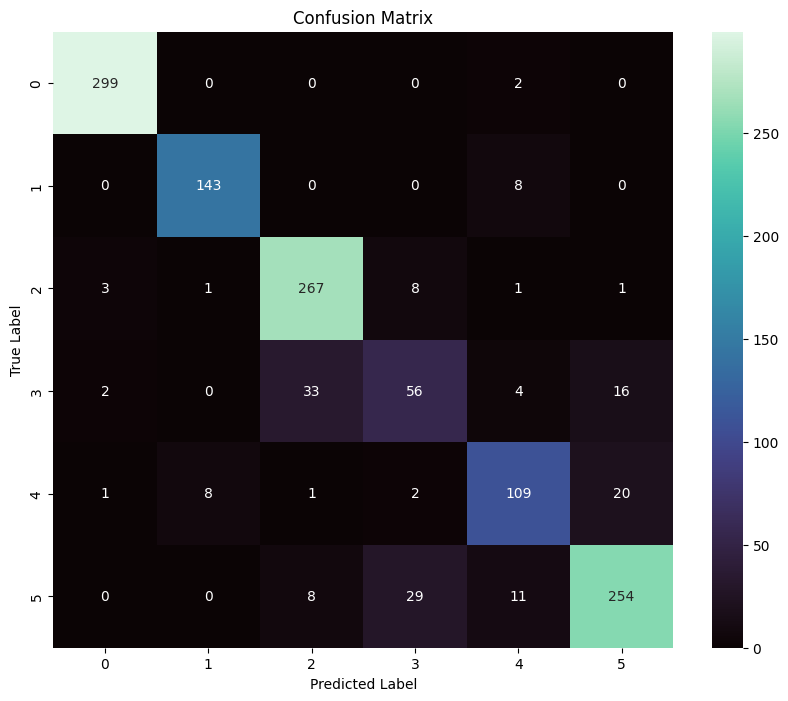

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)


y_pred = svm_linear.predict(X_test)

# Evaluate the model
accuracy, confusion_mat = evaluate(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
cm_matrix = pd.DataFrame(data=confusion_mat)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Gaussian RBF kernel

This kernel is a favorite choice in SVM, especially for data that doesn't line up straight. It's great for sorting data when you don't know much about it beforehand.

**Formula:**

$$F(x, x_j) = \exp{(-\gamma ||x - xj||^2)}$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous part.

Accuracy: 0.8749028749028749


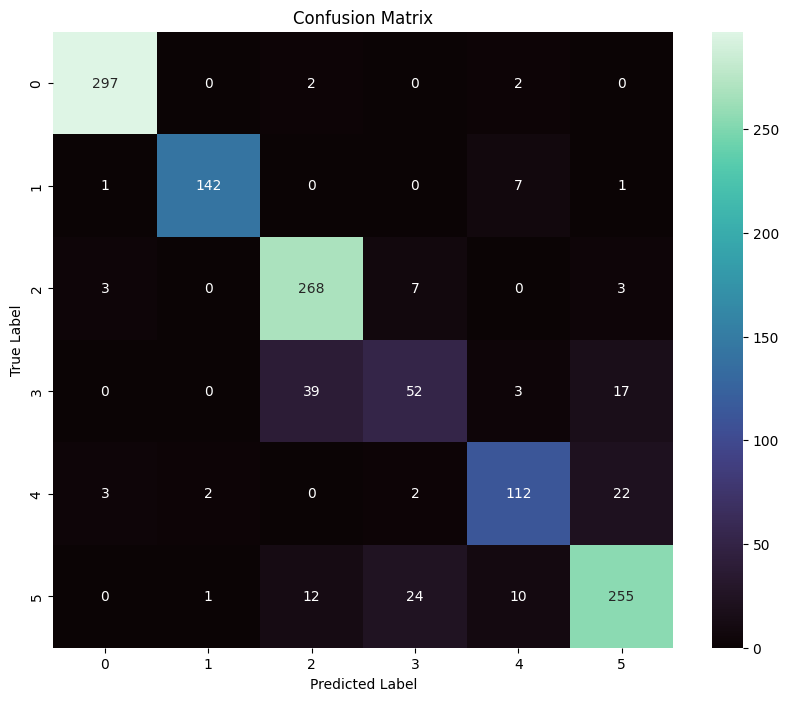

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

y_pred = svm_rbf.predict(X_test)

# Evaluate the model
accuracy, confusion_mat = evaluate(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
cm_matrix = pd.DataFrame(data=confusion_mat)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Polynomial Kernel

This is a broader version of the linear kernel. It's not as popular because it's not as quick or precise.

**Formula:**

$$F(x, x_j) = (x.x_j+1)^d$$

Now, set up the SVC classifier using a *polynomial* kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

Accuracy: 0.8694638694638694


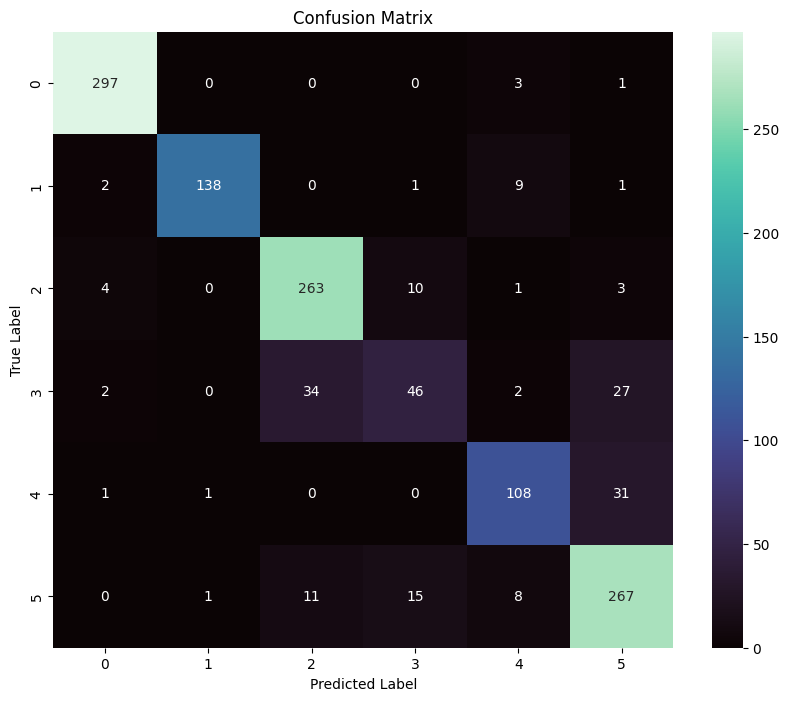

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

svm_poly = SVC(kernel='poly')
svm_poly.fit(X_train, y_train)


y_pred = svm_poly.predict(X_test)

# Evaluate the model
accuracy, confusion_mat = evaluate(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
cm_matrix = pd.DataFrame(data=confusion_mat)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Sigmoid Kernel

This is mainly chosen for use with neural networks. The kernel function acts like the activation function in a two-layer perceptron neural network model, helping to activate the neurons.

**Formula:**

$$F(x, x_j) = \tanh(α x a y + c)$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

Accuracy: 0.578088578088578


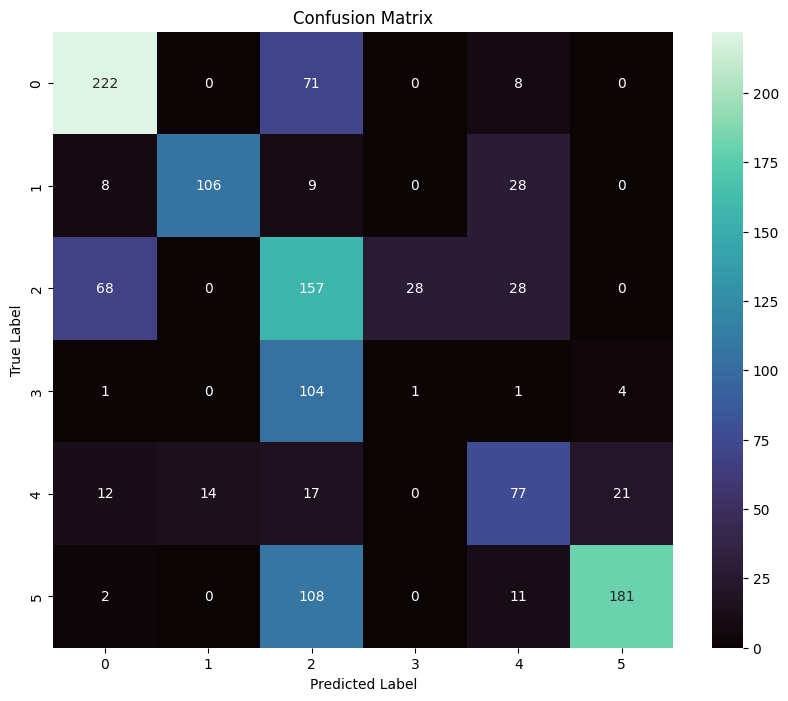

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


svm_sigmoid = SVC(kernel='sigmoid')
svm_sigmoid.fit(X_train, y_train)

y_pred = svm_sigmoid.predict(X_test)

# Evaluate the model
accuracy, confusion_mat = evaluate(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
cm_matrix = pd.DataFrame(data=confusion_mat)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Compare these four kernel functions with each other. What are the main advantages and disadvantages of each one?

### Comparison of Kernel Functions:

1. Linear Kernel:
   - **Advantages:**
     - Simplicity: Easy to interpret and implement.
     - Computationally efficient: Training and prediction times are typically faster compared to other kernel functions.
   - **Disadvantages:**
     - Limited flexibility: Only suitable for linearly separable data, may not perform well on non-linear datasets.

2. Gaussian RBF Kernel:
   - **Advantages:**
     - Flexibility: Can handle non-linear relationships between features.
     - Versatility: Works well with a wide range of datasets without requiring domain-specific knowledge.
   - **Disadvantages:**
     - Complexity: Computationally intensive, especially with large datasets.
     - Sensitivity to hyperparameters: Performance highly dependent on the choice of gamma parameter.

3. Polynomial Kernel:
   - **Advantages:**
     - Higher flexibility: Can capture more complex relationships between features compared to linear kernel.
     - Can handle non-linear data: Allows for transformation of input data into higher-dimensional space.
   - **Disadvantages:**
     - Computational complexity: Training time increases with higher polynomial degrees.
     - Risk of overfitting: Higher degrees can lead to overfitting, especially with small datasets.

4. Sigmoid Kernel:
   - **Advantages:**
     - Suitable for specific cases: May perform well on certain types of non-linear data, such as those resembling neural network activations.
   - **Disadvantages:**
     - Sensitivity to parameters: Performance highly dependent on the choice of parameters alpha and c.
     - Less commonly used: Not as widely applicable or versatile as other kernel functions.
